In [1]:
# Define Simulation Objects

const μ = 0.8  # Friction coefficient
const e = 0.8   # Coefficient of restitution for wall collisions

mutable struct Ball
    x::Float64   # x-coordinate
    y::Float64   # y-coordinate
    vx::Float64  # x-velocity
    vy::Float64  # y-velocity
    m::Float64   # mass
    r::Float64   # radius
end

struct Table
    length::Float64  # length of the table
    width::Float64   # width of the table
end

mutable struct GameInfo
    num_ball_collisions::Int64  # number of ball-ball collisions
    num_wall_collisions::Int64  # number of wall collisions
    num_balls_in_pocket::Int64  # number of balls in pocket
    GameInfo() = new(0, 0, 0);
end



In [2]:
function handle_ball_collision(ball1::Ball, ball2::Ball)
    dx = ball2.x - ball1.x
    dy = ball2.y - ball1.y
    
    angle = atan(dy, dx)
    min_distance = ball1.r + ball2.r
    distance = sqrt(dx^2 + dy^2)
    overlap = min_distance - distance

    # Move balls apart to avoid overlap
    ball1.x -= overlap / 2 * cos(angle)
    ball1.y -= overlap / 2 * sin(angle)
    ball2.x += overlap / 2 * cos(angle)
    ball2.y += overlap / 2 * sin(angle)

    # compute new velocities for two moving balls (elastic collision)
    angle1 = atan(ball1.vy, ball1.vx)
    angle2 = atan(ball2.vy, ball2.vx)
    new_angle1 = angle1 - angle
    new_angle2 = angle2 - angle

    v1 = sqrt(ball1.vx^2 + ball1.vy^2)
    v2 = sqrt(ball2.vx^2 + ball2.vy^2)

    new_vx1 = v2 * cos(new_angle2) * cos(angle) + v1 * sin(new_angle1) * cos(angle + pi / 2)
    new_vy1 = v2 * cos(new_angle2) * sin(angle) + v1 * sin(new_angle1) * sin(angle + pi / 2)
    new_vx2 = v1 * cos(new_angle1) * cos(angle) + v2 * sin(new_angle2) * cos(angle + pi / 2)
    new_vy2 = v1 * cos(new_angle1) * sin(angle) + v2 * sin(new_angle2) * sin(angle + pi / 2)

    ball1.vx = new_vx1
    ball1.vy = new_vy1
    ball2.vx = new_vx2
    ball2.vy = new_vy2
end

handle_ball_collision (generic function with 1 method)

In [3]:
function simulate_game_step(balls::Array{Ball,1}, table::Table, keyInfo::GameInfo, dt::Float64)
    # Simulate a single step of the game
    # Inputs:
    #   balls: array of balls
    #   table: table object
    #   dt: time step
    # Outputs:
    #   balls: updated array of balls
    #   table: updated table object

    # Update ball positions
    for ball in balls
        ball.x += ball.vx * dt
        ball.y += ball.vy * dt
    end

    # Check for collisions
    for i in 1:length(balls)
        for j in i+1:length(balls)
            ball1 = balls[i]
            ball2 = balls[j]
            if (ball1.x - ball2.x)^2 + (ball1.y - ball2.y)^2 <= (ball1.r + ball2.r)^2
                handle_ball_collision(ball1, ball2)
                keyInfo.num_ball_collisions += 1
            end
        end
    end

    # Check for collisions with walls
    for ball in balls
        if ball.x <= ball.r || ball.x >= table.length - ball.r
            ball.x = clamp(ball.x, ball.r, table.length - ball.r)
            ball.vx = -e * ball.vx
        end
        if ball.y <= ball.r || ball.y >= table.width - ball.r
            ball.y = clamp(ball.y, ball.r, table.width - ball.r)
            ball.vy = -e * ball.vy
        end
        if ball.x <= ball.r || ball.x >= table.length - ball.r || ball.y <= ball.r || ball.y >= table.width - ball.r
            keyInfo.num_wall_collisions += 1
        end
    end

    # Update ball velocities
    for ball in balls
        ball.vx -= μ * ball.vx * dt
        ball.vy -= μ * ball.vy * dt
    end

    return balls, table
end

simulate_game_step (generic function with 1 method)

In [4]:
using Plots
function visualize_game_state(balls::Array{Ball,1}, table::Table)
    # Visualize a game at one point in time
    # Inputs:
    #   balls: array of balls
    #   table: table object

    plt = plot(xlim=(0, table.length), ylim=(0, table.width), aspect_ratio=1, legend=false)
    # Plot the table
    plot!(plt, [0, table.length, table.length, 0, 0], [0, 0, table.width, table.width, 0], color=:black)
    # Plot the balls
    for ball in balls
        plot!(plt, [ball.x], [ball.y], st=:scatter, ms=ball.r*215, color=:red)
    end

end

function simulate_game(balls::Array{Ball,1}, table::Table, dt::Float64, n_steps::Int64, visualize::Bool = false)
    # Simulate a game
    # Inputs:
    #   balls: array of balls
    #   table: table object
    #   dt: time step
    #   n_steps: number of steps to simulate
    # Outputs:
    #   balls: updated array of balls
    #   table: updated table object

    # Simulate the game
    if visualize
    @gif for i in 1:n_steps
        balls, table = simulate_game_step(balls, table, dt)

        if visualize
            visualize_game_state(balls, table)
        end
    end
    else
        for i in 1:n_steps
            balls, table = simulate_game_step(balls, table, dt)
        end
    end
end

simulate_game (generic function with 2 methods)

In [5]:
# import Pkg; Pkg.add("Gen")

In [6]:
using Gen

@gen function billiards_stroke_probabilistic(cue_ball::Ball, other_balls::Array{Ball,1}, table::Table, gameInfo::GameInfo, dt::Float64, n_steps::Int64)
    cue_ball_velocity = ({:cue_ball_velocity} ~ gamma(9, 0.2))
    cue_ball_shot_direction = ({:cue_ball_shot_direction} ~ uniform(0, 2*pi))
    cue_ball_vx = cue_ball_velocity * cos(cue_ball_shot_direction)
    cue_ball_vy = cue_ball_velocity * sin(cue_ball_shot_direction)
    new_cue_ball = Ball(cue_ball.x, cue_ball.y, cue_ball_vx, cue_ball_vy, cue_ball.m, cue_ball.r)
    other_balls_copy = deepcopy(other_balls)
    balls = [new_cue_ball; other_balls_copy]

    states = [deepcopy(balls)]
    function check_balls_stopped(balls::Array{Ball,1})
        for ball in balls
            if abs(ball.vx) > 0.01 || abs(ball.vy) > 0.01
                return false
            end
        end
        return true
    end
    current_step = 0
    finished = false 

    while !check_balls_stopped(balls) && !finished
        balls, table = simulate_game_step(balls, table, gameInfo, dt)
        push!(states, deepcopy(balls))
        current_step += 1
        if current_step > n_steps && n_steps > 0
            finished = true
        end
    end
    for (i, ball) in enumerate(states[end])
        {(:final_state, i, :x)} ~ normal(ball.x, ball.r/4)
        {(:final_state, i, :y)} ~ normal(ball.y, ball.r/4)
        {(:final_state, i, :vx)} ~ normal(ball.vx, abs(ball.vx) < 0.01 ? 0.001 : 0.1)
        {(:final_state, i, :vy)} ~ normal(ball.vy, abs(ball.vy) < 0.01 ? 0.001 : 0.1)
    end
    return states, gameInfo
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Ball, Vector{Ball}, Table, GameInfo, Float64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], var"##billiards_stroke_probabilistic#294", Bool[0, 0, 0, 0, 0, 0], false)

In [7]:
function do_inference_on_stroke(model, cue_ball_init_x::Float64, cue_ball_init_y::Float64, other_balls::Array{Ball,1}, table::Table, observed_final_state::Array{Pair{Int64, Ball}, 1}, num_sim_steps::Int64, amount_of_computation::Int64)
    cue_ball = Ball(cue_ball_init_x, cue_ball_init_y, 0.0, 0.0, 1.0, 0.0285)
    observations = Gen.choicemap()
    for p in observed_final_state
        i = p.first
        ball = p.second
        observations[(:final_state, i, :x)] = ball.x
        observations[(:final_state, i, :y)] = ball.y
        observations[(:final_state, i, :vx)] = ball.vx
        observations[(:final_state, i, :vy)] = ball.vy
    end

    dt = 0.01

    (trace, _) = Gen.importance_resampling(model, (cue_ball, other_balls, table, gameInfo, dt, num_sim_steps), observations, amount_of_computation)
    return trace
end

do_inference_on_stroke (generic function with 1 method)

In [8]:
function trace_to_gif(trace)
    states, _ = Gen.get_retval(trace)
    table = Gen.get_args(trace)[3]
    @gif for balls in states
        visualize_game_state(balls, table)
    end
end

trace_to_gif (generic function with 1 method)

In [177]:
colors = [:blue, :green, :yellow, :orange, :purple, :brown]
light_red = RGB(1, 0.5, 0.5)
function visualize_cue_ball_paths(traces)
    table = Gen.get_args(traces[1])[3]
    plt = plot(xlim=(0, table.length), ylim=(0, table.width), aspect_ratio=1, legend=false)
    for (i, trace) in enumerate(traces)
        states, _ = Gen.get_retval(trace)
        color = colors[(i % length(colors)) + 1]
        for state in states
            cue_ball = state[1]
            plot!(plt, [cue_ball.x], [cue_ball.y], st=:scatter, ms=cue_ball.r*215, color=color)
        end
        other_ball = states[end][end]
        plot!(plt, [other_ball.x], [other_ball.y], st=:scatter, ms=other_ball.r*215, color=light_red)

    end
    other_balls = Gen.get_args(traces[1])[2]
    other_ball = other_balls[end]
    plot!(plt, [other_ball.x], [other_ball.y], st=:scatter, ms=other_ball.r*215, color=:red)
    return plt
end

    
    

visualize_cue_ball_paths (generic function with 1 method)

In [170]:
function build_ball_pyramid()
    balls  = Vector{Ball}()
    for i in 1:5
        for j in 1:i
            push!(balls, Ball(0.5 + 0.0285 * (i - 1), 0.5 + 0.0285 * (j - 1), 0.0, 0.0, 1.0, 0.0285))
        end
    end
    return balls
end

build_ball_pyramid (generic function with 1 method)

In [171]:
# goal_state = [2 => Ball(0.8, 0.5, 0, 0, 1, 0.0285)]
# cue_ball_init_x = 0.5
# cue_ball_init_y = 0.5
# other_balls = [Ball(0.8, 0.3, 0, 0, 1, 0.0285)]
# table = Table(2.54, 1.27)
# gameInfo = GameInfo()
# stroke_for_goal_trace = do_inference_on_stroke(billiards_stroke_probabilistic, cue_ball_init_x, cue_ball_init_y, other_balls, table, goal_state, -1, 500)

In [172]:
# goal_state = [1 => Ball(1.65, 1, 0, 0, 1, 0.0285), 2 => Ball(1.25, 1.25, 0, 0, 1, 0.0285)]
# cue_ball_init_x = 0.5
# cue_ball_init_y = 0.8
# other_balls = [Ball(1.25, 1, 0, 0, 1, 0.0285)]
# table = Table(2.54, 1.27)
# gameInfo = GameInfo()

In [185]:
goal_state = [4 => Ball(1.5, 0.8, 0, 0, 1, 0.0285)]
other_balls = [Ball(0.75, 0.5, 0, 0, 1, 0.0285),  Ball(0.75+2*0.0285, 0.5+0.0285, 0, 0, 1, 0.0285), Ball(0.75+2*0.0285, 0.5-0.0285, 0, 0, 1, 0.0285), Ball(0.75+4*0.0285, 0.5, 0, 0, 1, 0.0285)]
cue_ball_init_x = 0.1
cue_ball_init_y = 0.5
table = Table(2.54, 1.27)
gameInfo = GameInfo()


GameInfo(0, 0, 0)

In [186]:
function visualize_init_state_and_goals(trace, goals)
    table = Gen.get_args(trace)[3]
    plt = plot(xlim=(0, table.length), ylim=(0, table.width), aspect_ratio=1, legend=false)
    states, _ = Gen.get_retval(trace)
    init_state = states[1]

    # plot cue ball as white
    cue_ball = init_state[1]
    plot!(plt, [cue_ball.x], [cue_ball.y], st=:scatter, ms=cue_ball.r*215, color=:blue)
    
    for ball in init_state[2:end]
        plot!(plt, [ball.x], [ball.y], st=:scatter, ms=ball.r*215, color=:red)
    end

    # plot goal as X mark
    for goal in goals
        goal_x = goal[1]
        goal_y = goal[2]
        plot!(plt, [goal_x], [goal_y], st=:scatter, ms=cue_ball.r*215, color=:green, markershape=:xcross)
    end
    display(plt)
    
end

visualize_init_state_and_goals (generic function with 1 method)

In [187]:
stroke_options_for_goal = [do_inference_on_stroke(billiards_stroke_probabilistic, cue_ball_init_x, cue_ball_init_y, other_balls, table, goal_state, -1, 500) for i in 1:5]

5-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Ball, Vector{Ball}, Table, GameInfo, Float64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing], var"##billiards_stroke_probabilistic#294", Bool[0, 0, 0, 0, 0, 0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:final_state, 5, :y) => Gen.ChoiceOrCallRecord{Float64}(0.7941233155615643, 3.936770735873914, NaN, true), (:final_state, 5, :vy) => Gen.ChoiceOrCallRecord{Float64}(0.004729122908583796, 5.462003116314228, NaN, true), (:final_state, 1, :y) => Gen.ChoiceOrCallRecord{Float64}(1.1749740889455291, 3.7582448133956476, NaN, true), :cue_ball_shot_direction => Gen.ChoiceOrCallRecord{Float64}(0.05318851210662169, -1.8378770664093453, NaN, true), (:final_state, 3, :vx) => Gen.ChoiceOrCallRecord{Float64}(-2.956784590255339e-5, 5.988379617

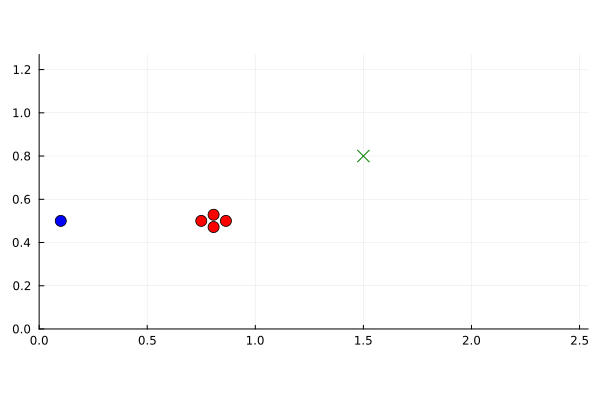

In [188]:
visualize_init_state_and_goals(stroke_options_for_goal[1], [[1.5, 0.8]])

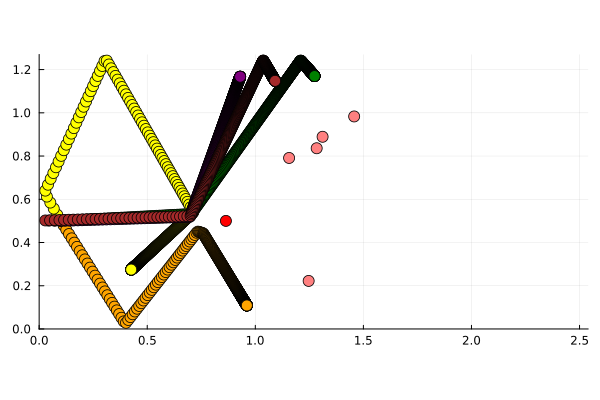

In [189]:
visualize_cue_ball_paths(stroke_options_for_goal[1:end])

In [184]:
Gen.get_choices(stroke_for_goal_trace)

LoadError: UndefVarError: `stroke_for_goal_trace` not defined

[ Info: Saved animation to /Users/kairomorton/Documents/MIT/Senior Year/6.4120/Billiards Final Project/tmp.gif


Plots.AnimatedGif("/Users/kairomorton/Documents/MIT/Senior Year/6.4120/Billiards Final Project/tmp.gif")
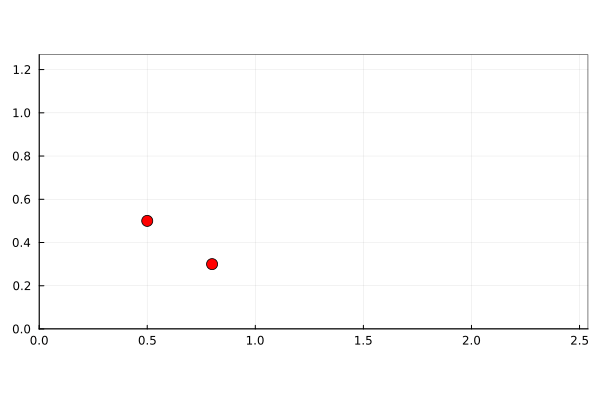

In [ ]:
rand_idx = rand(1:length(stroke_options_for_goal))
trace_to_gif(stroke_options_for_goal[rand_idx])

In [ ]:
cue_ball_init = Ball(0.5, 0.5, 0, 0, 1, 0.0285)
other_balls = [Ball(0.1, 0.1, 0, 0, 1, 0.0285)]
table = Table(2.54, 1.27)
trace = Gen.simulate(billiards_stroke_probabilistic, (cue_ball_init, other_balls, table, GameInfo(), 0.01, -1));

In [ ]:
Gen.get_choices(trace)

│
├── :cue_ball_shot_direction : 1.491117976762146
│
└── :cue_ball_velocity : 0.6245474121939613
